In [26]:
from sklearn.linear_model import LogisticRegression 
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# set random state to use
rs = 25

In [2]:
# import saved data from clean-up done in Random Forest modeling process
data = pd.read_csv('../Data/gss_subset_for_modeling.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11534 entries, 0 to 11533
Data columns (total 8 columns):
marital    11534 non-null object
sibs       11534 non-null float64
childs     11534 non-null float64
age        11534 non-null float64
educ       11534 non-null float64
adults     11534 non-null float64
happy      11534 non-null float64
dwelown    11534 non-null object
dtypes: float64(6), object(2)
memory usage: 720.9+ KB


In [9]:
# set X and y.drop non-demographic features(ie would need to be collected in interview)
X = pd.get_dummies(data.drop('happy', axis=1), drop_first=True)
y = data['happy'] == 1 # y is "true" when individual is unhappy

In [18]:
# do train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
        stratify = y, test_size=0.2, random_state=rs)

In [19]:
C_range = 10.**np.arange(-2, 3)
param_grid = {'C':C_range, 'fit_intercept':[True, False], 
              'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag']}

In [20]:
log_reg = LogisticRegression(random_state = rs, n_jobs=-1)

In [21]:
grid = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/utils/optimize.py:193: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=25, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [22]:
# print best parameters and score, as well as out of sample score
print grid.best_estimator_
print grid.best_score_
print grid.score(X_test, y_test)

LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=25,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)
0.685256049139
0.710898119277


/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [24]:
# Calculate prediction probabilities, use threshold of 15% to classify as unhappy
grid_proba = grid.predict_proba(X_test)
grid_pred = grid_proba[:,1] > 0.15
print classification_report(y_test, grid_pred)
print confusion_matrix(y_test, grid_pred)

             precision    recall  f1-score   support

      False       0.92      0.64      0.76      1979
       True       0.24      0.67      0.35       328

avg / total       0.83      0.65      0.70      2307

[[1273  706]
 [ 107  221]]


## Plot ROC curve and Value-Add plot

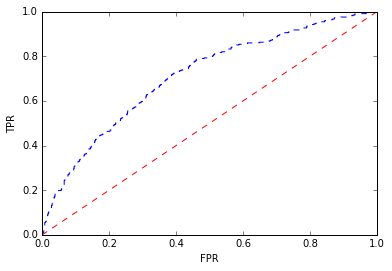

In [27]:
# look at ROC curve for model with more features and less features
fpr, tpr, _ = metrics.roc_curve(y_test, grid_proba[:,1])
plt.plot(fpr, tpr, 'b--', fpr, fpr, 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [30]:
def getPlotValueAdd(probas, y_test):
    # create dataframe with the model's predicted P(unhappy) along with boolean for actual unhappiness
    modelprobs = pd.DataFrame()
    modelprobs['Model_Prob_Unhappy'] = probas[:,1]
    modelprobs['Unhappy_True'] = y_test.as_matrix()

    # sort by P(Unhappy) and add columns for % Unhappy and % Happy people falling above that threshold
    modelprobs.sort_values(by='Model_Prob_Unhappy', axis=0, inplace=True, ascending=False)
    modelprobs['portion_unhappy_captured'] = np.cumsum(modelprobs['Unhappy_True'])/np.sum(modelprobs['Unhappy_True'])
    modelprobs['portion_happy_mislabeled'] = np.cumsum(1-modelprobs['Unhappy_True'])/np.sum(1-modelprobs['Unhappy_True'])
    # add column with ratio of correct prediction (ie, precision for predicting unhappiness)
    modelprobs['ratio_correct_prediction'] = np.cumsum(modelprobs['Unhappy_True'])/(np.cumsum(modelprobs['Unhappy_True']) + np.cumsum(1-modelprobs['Unhappy_True']))

    # Plot the difference
    x = modelprobs['Model_Prob_Unhappy']
    y1 = modelprobs['portion_unhappy_captured']
    y2 = modelprobs['portion_happy_mislabeled']
    y3 = modelprobs['ratio_correct_prediction']
    plt.plot(x, y1, 'b--', x, y2, 'r--', x, y3, 'g--')
    
    # return DF
    return modelprobs

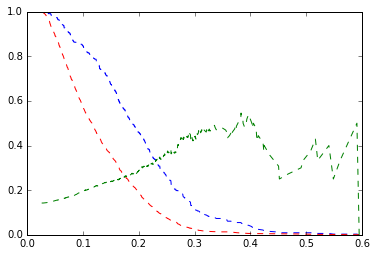

In [31]:
# look at value add for logistic regression
modelprobs = getPlotValueAdd(grid_proba, y_test)